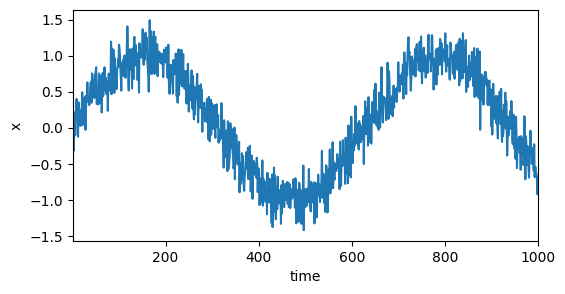

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np

# 生成时间步
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
# 生成带噪声的正弦序列
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

# 用 matplotlib 绘图
plt.figure(figsize=(6, 3))
plt.plot(time.numpy(), x.numpy())  # torch.Tensor 转 numpy 数组用于绘图
plt.xlabel('time')
plt.ylabel('x')
plt.xlim([1, 1000])
plt.show()


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader

tau = 4
T = 1000  # 前面代码里定义过的 T，这里假设已定义好
# 生成 features，和原来逻辑一致
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))  # 将张量重塑为二维，每行1个元素

batch_size, n_train = 16, 600
# 构建 TensorDataset，将特征和标签组合
train_dataset = TensorDataset(features[:n_train], labels[:n_train])
# 构建 DataLoader，用于按批次加载数据，shuffle=True 表示训练时打乱数据
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)  # 常用来初始化 nn.Linear（全连接层 ）、nn.Conv2d（卷积层 ）等的权重


def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net


loss = nn.MSELoss()

In [4]:
def evaluate_loss(net, data_iter, loss):
    """评估损失"""
    total_loss = 0
    for X, y in data_iter:
        y_pred = net(X)
        l = loss(y_pred, y)
        total_loss += l.item()
    return total_loss / len(data_iter)


def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        # 训练完一轮后评估损失
        epoch_loss = evaluate_loss(net, train_iter, loss)
        print(f'epoch{epoch + 1}', f'loss {epoch_loss}')


net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch1 loss 0.07473593607152763
epoch2 loss 0.05642460570915749
epoch3 loss 0.049519811511824004
epoch4 loss 0.0546322541899587
epoch5 loss 0.04691394994427499


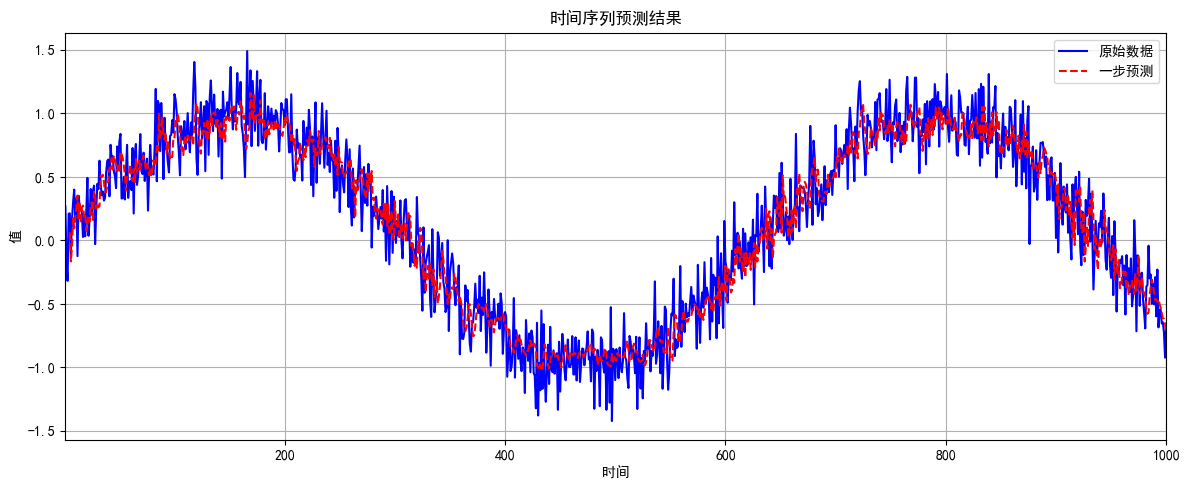

In [5]:
# 设置中文字体显示
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


def predict_and_plot(model, features, time, x, tau):
    """执行预测并可视化结果"""
    model.eval()
    with torch.no_grad():
        onestep_preds = model(features).numpy().flatten()

    # 绘制原始数据和预测结果
    plt.figure(figsize=(12, 5))
    plt.plot(time, x, 'b-', label='原始数据')
    plt.plot(time[tau:], onestep_preds, 'r--', label='一步预测')
    plt.title('时间序列预测结果')
    plt.xlabel('时间')
    plt.ylabel('值')
    plt.xlim(1, 1000)  # 只显示前100个点，便于观察
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


predict_and_plot(net, features, time, x, tau)

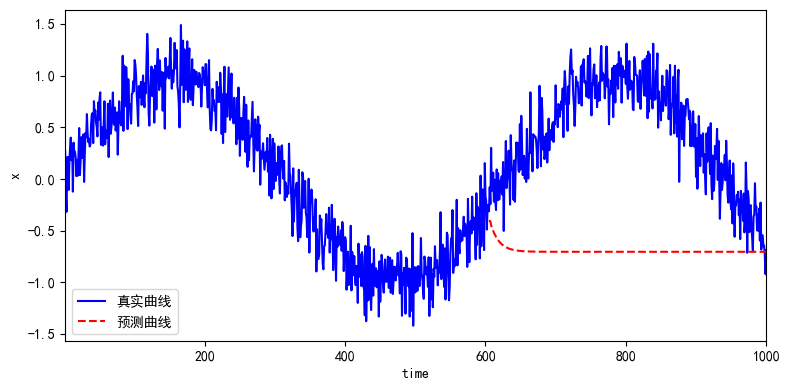

In [10]:
multistep_preds = torch.zeros(T)
# 初始化：前n_train+tau个点用真实值填充
multistep_preds[:n_train + tau] = x[:n_train + tau]

# 从n_train_tau开始往后预测
for i in range(n_train + tau, T):
    # 取前tau个点作为输入，reshape成模型需要的维度（1,tau）
    input_seq = multistep_preds[i - tau:i].reshape(1, -1)
    # 模型预测（ squeeze 去掉 batch 维度，得到标量预测值 ）
    multistep_preds[i] = net(input_seq).squeeze()

# 4. 使用 Matplotlib 绘图
# --------------------------- 绘图 ---------------------------
plt.figure(figsize=(8, 4))
# 绘制两条曲线
plt.plot(time, x, 'b-', label='真实曲线')
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(), 'r--', label='预测曲线')
plt.xlabel('time')
plt.ylabel('x')
# 显示图例
plt.legend()
# x 轴范围
plt.xlim([1, 1000])
plt.tight_layout()
# 显示图像
plt.show()